<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=c2287e4a5c1a218b18aa5cee71e3ee3005676972d7518ef94a8e57ecc72e3e33
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [3]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [4]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [16]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(uniqueSampleNum, sampleNumber):

  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(uniqueSampleNum)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)
  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))

  fullGaussMatrix = np.repeat(gaussTotal,repeats=sampleNumber,axis=0)
  dataPoisson = np.random.poisson(lam=fullGaussMatrix,size=None)

  fullthetaData = np.repeat(thetaData,repeats=sampleNumber,axis=0)

  return dataPoisson, fullthetaData

dataPoisson, thetaData = generateTrainingData(10000,1000)




In [7]:
print(thetaData[999:1001])
print(dataPoisson[999:1001])

[[38.11326539  1.14188786  1.8054577  19.35588386  6.36003954  5.67251996]
 [27.71478449  1.16198264  2.78503538 29.02185883  7.22710602  6.20521619]]
[[12 10  6  8  2  4  0  2  1  2]
 [ 8  2  3  7  4  3  4  2  0  2]]


In [8]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [9]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0


100%|██████████| 5/5 [03:16<00:00, 39.35s/it]

5


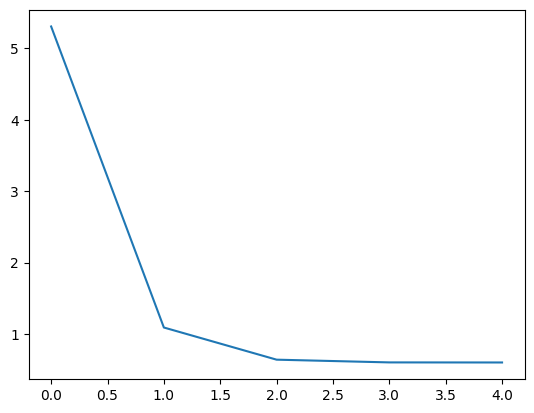

In [10]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)

In [11]:
print(r_losses[-1])

0.6002334522527325


[10.997857   16.004025   11.00635     2.0038822   4.988723    0.87076366
  1.0894222   1.0770333   1.0689824   1.0336341 ]
[11. 16. 11.  2.  5.  1.  1.  1.  0.  2.]


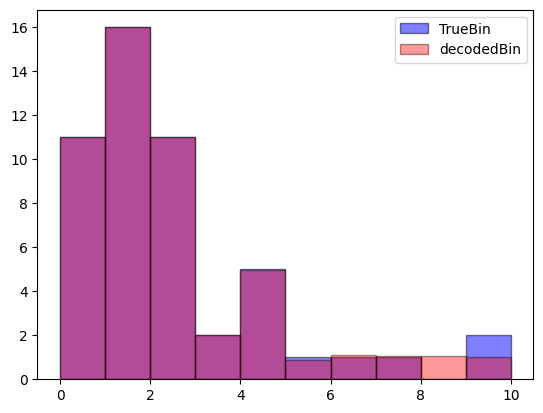

In [12]:
testP,_ = generateTrainingData(1,1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [10]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)


In [11]:
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-3)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         1,740
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         1,740
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         1,740
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         1,740
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        1,740
│    │    └─Rever

In [ ]:
batch_size = 1000
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 100 == 0):
      print(f"nll:{cnf_loss}")

    cnf_loss.backward()
    flowOptim.step()





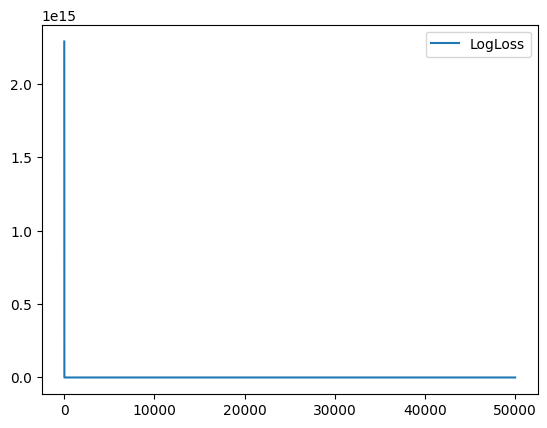

10.123469352722168


In [19]:
plt.plot(logLoss,label="LogLoss")
plt.legend()
plt.show()

print(logLoss[-1])

In [18]:
torch.save({
    "cnf": CNFModel.state_dict(),
    "optimizer": flowOptim.state_dict(),
}, "CNF_params_Optim.pth")

torch.save({
    "ae": encodeModel.state_dict(),\
    "AE_Optim": reconOptim.state_dict(),
}, "AE_params_Optim.pth")


In [6]:
ckpt_AE  = torch.load("AE_params_Optim.pth", map_location=device)
ckpt_CNF = torch.load("CNF_params_Optim.pth", map_location=device)

In [12]:
encodeModel.load_state_dict(ckpt_AE["ae"])
CNFModel.load_state_dict(ckpt_CNF["cnf"])

encodeModel.eval()
CNFModel.eval()


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=16, bias=True)
          (context_layer): Linear(in_features=6, out_features=16, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (context_layer): Linear(in_features=6, out_features=16, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=16, out_features=16, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=16, out_features=12, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=16, bias=True)
   

In [27]:
N1,mu1,sig1,N2,mu2,sig2 = generatePrior(1000)

(array([ 93.,  90., 103.,  90., 108.,  97., 102.,  89., 114., 114.]),
 array([10.03950587, 14.02396996, 18.00843405, 21.99289814, 25.97736223,
        29.96182632, 33.94629041, 37.9307545 , 41.91521859, 45.89968268,
        49.88414677]),
 <BarContainer object of 10 artists>)

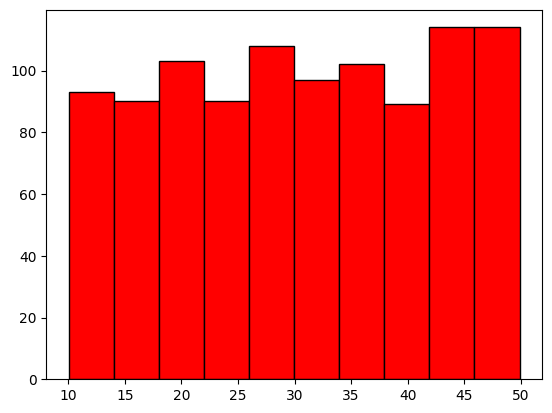

In [53]:
plt.hist(N1,color="red",edgecolor="black")
#plt.hist(N2,color="red",edgecolor="black")
#plt.hist(mu1,color="red",edgecolor="black")
#plt.hist(mu2,color="red",edgecolor="black")
#plt.hist(sig1,color="red",edgecolor="black")
#plt.hist(sig2,color="red",edgecolor="black")

In [54]:
cnfP, cnfT = generateTrainingData(1,1)
cnfP_tensor = torch.tensor(cnfP, requires_grad=False).float().to(device)

cnfP_en = encodeModel.encode(cnfP_tensor)

print(cnfP_en)
print(cnfT)


tensor([[ 3.7650,  5.3351, -5.2844, -3.1934,  6.5926, -8.0504]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
[[26.9006837   1.46905919  2.46107653 26.09063713  8.4862636   5.16188425]]


In [55]:
with torch.no_grad():
  samples = CNFModel.sample(10000,context=cnfP_en).cpu().numpy()
samples = samples[0,:,:]

(array([  38.,  989., 3178., 2905., 1642.,  828.,  291.,   97.,   23.,
           9.]),
 array([ 2.49633789,  7.3511734 , 12.20600891, 17.06084442, 21.91567993,
        26.77051544, 31.62535095, 36.48018646, 41.33502197, 46.18985748,
        51.04469299]),
 <BarContainer object of 10 artists>)

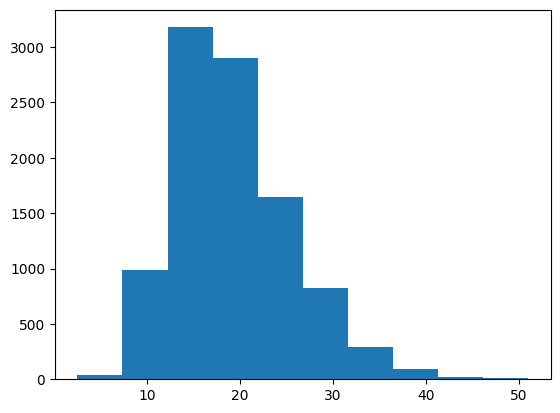

In [56]:
N1_cnf = samples[:,0]
plt.hist(N1_cnf)

(array([  35.,  415., 1396., 2364., 2451., 1830., 1006.,  412.,   85.,
           6.]),
 array([0.26481414, 0.60032213, 0.93583018, 1.27133822, 1.60684621,
        1.9423542 , 2.27786231, 2.61337018, 2.94887829, 3.2843864 ,
        3.61989427]),
 <BarContainer object of 10 artists>)

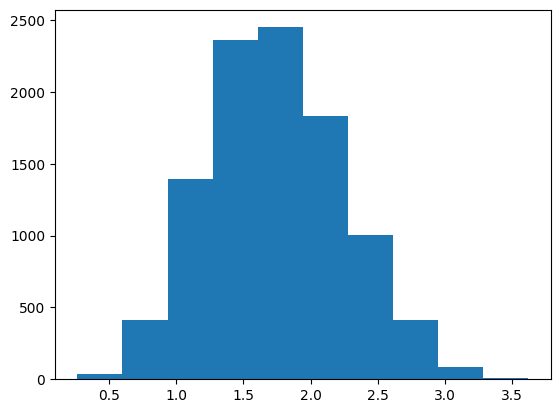

In [57]:
mu1_cnf = samples[:,1]
plt.hist(mu1_cnf)
